In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os,random, math, psutil, pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

import json

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import gc

pd.set_option('max_columns', 100)

# 4. Make X and y

In [2]:
train = pd.read_pickle('../data/processed/train.pkl')

# rolling average by day
train = train.set_index('timestamp')
# train['meter_reading'] = train['meter_reading'].rolling('D').mean()

# cols = ['hour', 'dayofyear', 'weekofyear', 'month']
# train[cols] = train[cols].astype('category')

def make_X_y(train):    
    X = train.drop(['meter_reading'], axis=1)
    y = np.log1p(train['meter_reading'])
    return X, y
X, y = make_X_y(train)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20216100 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 17 columns):
 #   Column             Dtype   
---  ------             -----   
 0   building_id        int16   
 1   meter              int8    
 2   site_id            int8    
 3   primary_use        category
 4   square_feet        int32   
 5   year_built         float64 
 6   floor_count        float64 
 7   air_temperature    float64 
 8   cloud_coverage     float64 
 9   dew_temperature    float64 
 10  precip_depth_1_hr  float64 
 11  wind_speed         float64 
 12  hour               int8    
 13  dayofyear          int16   
 14  weekofyear         int8    
 15  month              int8    
 16  beaufort_scale     float64 
dtypes: category(1), float64(8), int16(2), int32(1), int8(5)
memory usage: 1.6 GB


In [4]:
y

timestamp
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
                         ...   
2016-12-31 23:00:00    2.277267
2016-12-31 23:00:00    1.762159
2016-12-31 23:00:00    0.000000
2016-12-31 23:00:00    5.078761
2016-12-31 23:00:00    1.348073
Name: meter_reading, Length: 20216100, dtype: float32

# 5. Light gradient boosting

### 5.1 KFold without shuffling

In [5]:
%%time
models = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X):
    
    # split train and test set
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval testing data
                      categorical_feature=['primary_use', 'hour', 'dayofyear', 'weekofyear', 'month'], 
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    #ypred = model.predict(X_test)
    #plt.plot(ypred/y_test)
    # model.save_model('')
    
    models.append(model)
    
# models.save_model('models-5fold.txt')

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.07818
[50]	valid_0's rmse: 0.993124
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.973493
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.27827
[50]	valid_0's rmse: 1.22245
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.20618
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.39272
[50]	valid_0's rmse: 1.36599
Did not meet early stopping. Best iteration is:
[67]	valid_0's rmse: 1.36095
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.12816
[50]	valid_0's rmse: 1.08787
Did not meet early stopping. Best iteration is:
[66]	valid_0's rmse: 1.08341
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.2694
[50]	valid_0's rmse: 1.25934
Did not meet early stopping. Best iteration is:
[64]	valid_0's rmse: 1.25701
Wall time: 13min 38

In [6]:
kf = KFold(n_splits=5, shuffle=False)
scores = []
i = 0
for train_index, test_index in kf.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    i += 1   

In [7]:
def print_results(scores):
    [print(i) for i in (np.round(scores, 3))]
    avg = np.round(np.mean(scores), 3)
    print(f'average: {avg}')

def plot_importances(models):
    for model in models:
        fig, axes = plt.subplots(figsize=(12, 10))
        lgb.plot_importance(model, ax=axes)
        plt.show()

1.425
1.208
1.28
1.226
1.287
average: 1.285


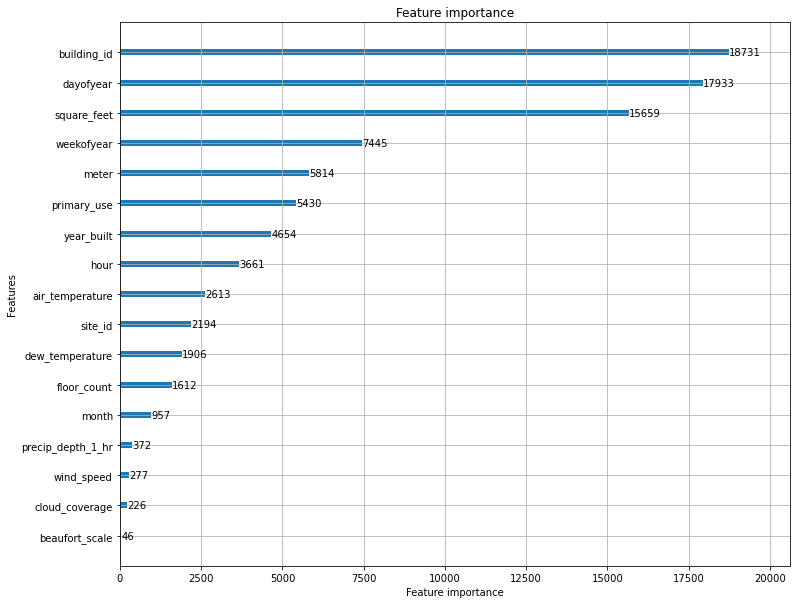

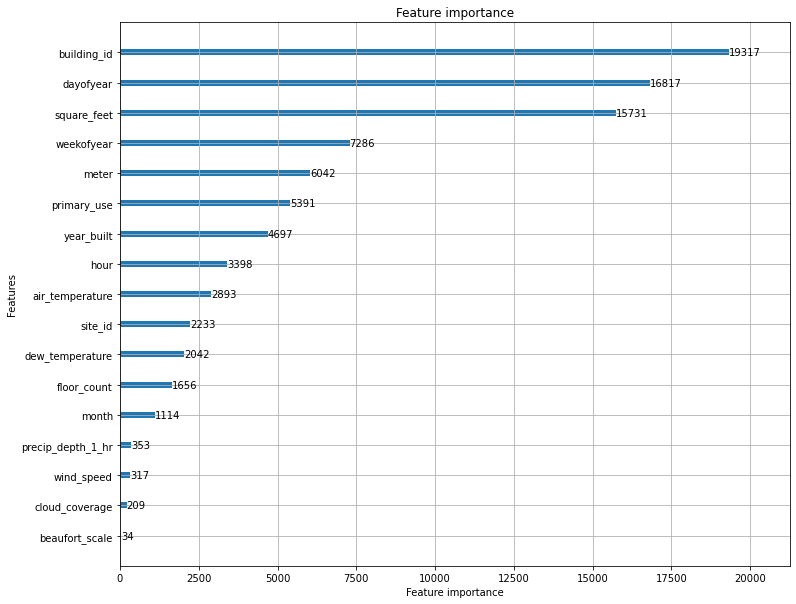

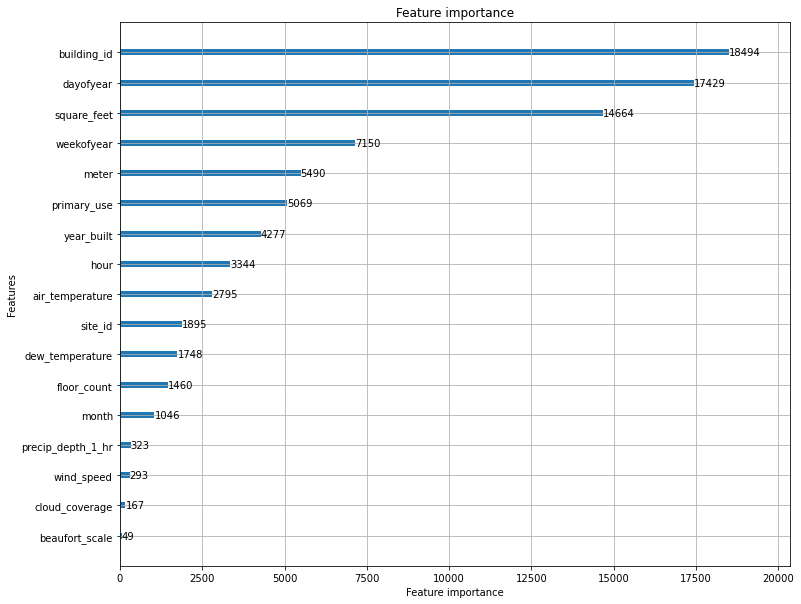

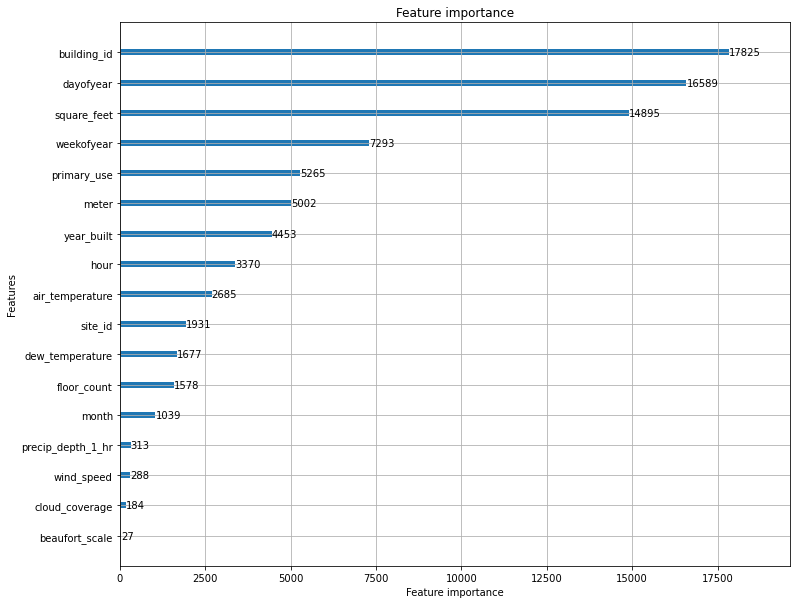

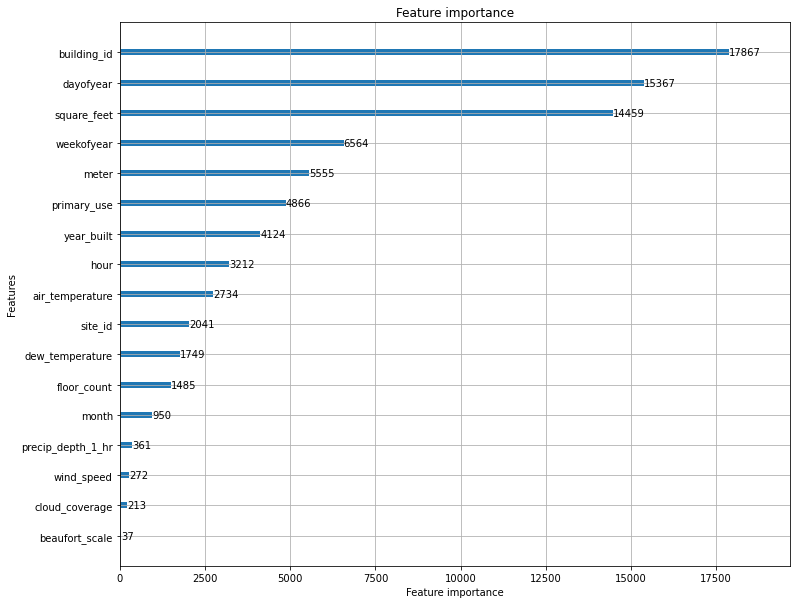

In [8]:
print_results(scores)
plot_importances(models)

### 5.2 TimeSeriesSplit
Its cross validation behavious is illustrated below.

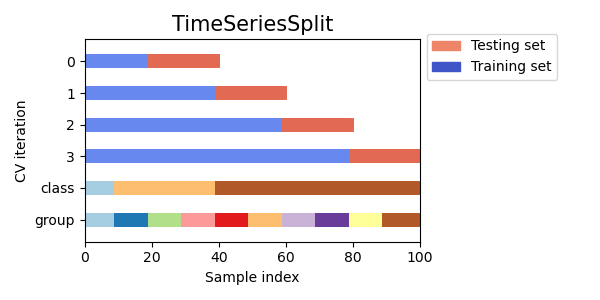

In [9]:
%%time
models = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    # split train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval training data
                      categorical_feature="auto",
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.01765
[50]	valid_0's rmse: 0.968602
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.961065
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.39324
[50]	valid_0's rmse: 1.38605
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.38123
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.74163
[50]	valid_0's rmse: 1.83082
Early stopping, best iteration is:
[13]	valid_0's rmse: 1.67572
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.17398
[50]	valid_0's rmse: 1.14457
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.13808
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.05698
[50]	valid_0's rmse: 0.969778
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.95154
Wall time: 6min 43s


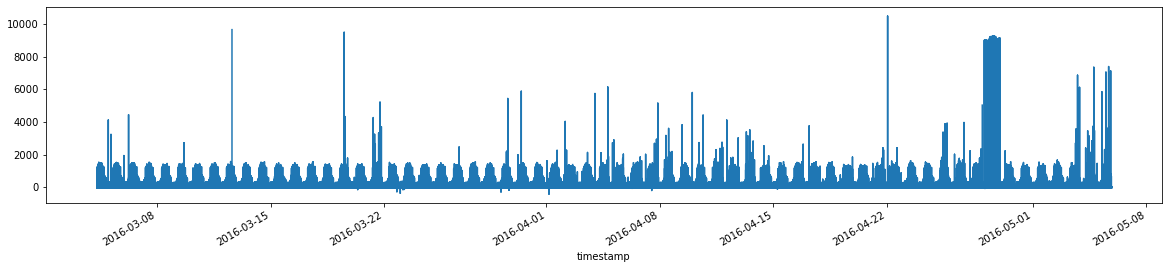

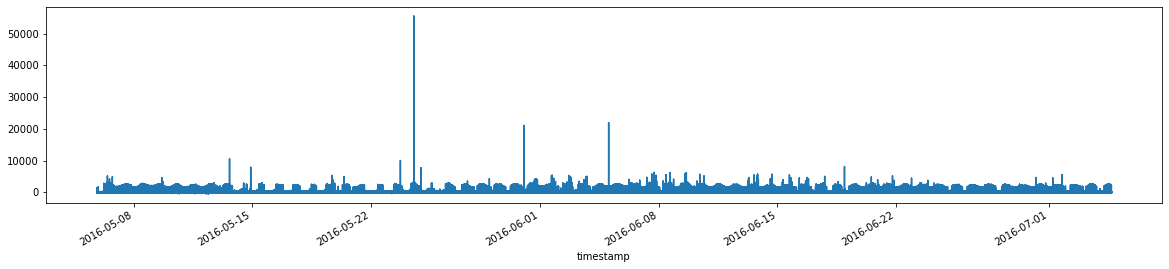

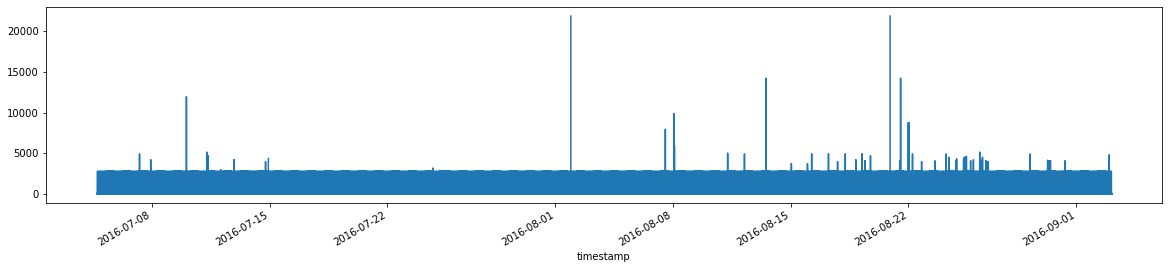

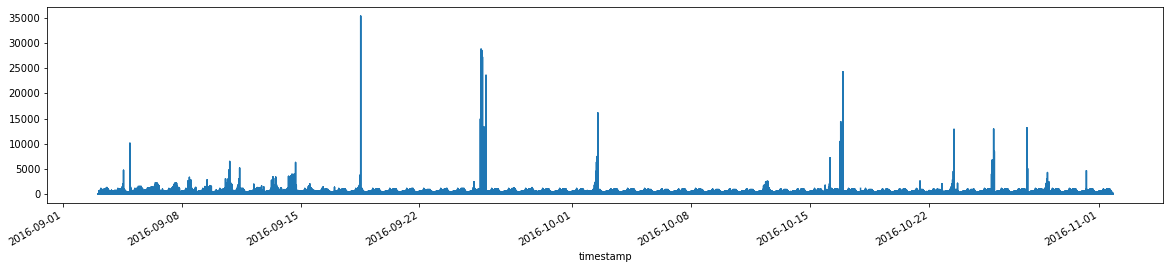

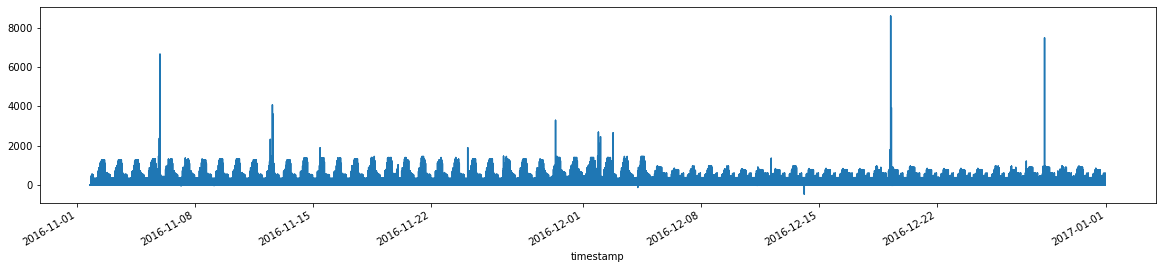

In [10]:
i = 0
scores = []
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    i += 1
    
    # fig, axes = plt.subplots(figsize=(20, 4))
    # (y_pred / y_test).plot()    

0.961
1.381
1.676
1.138
0.952
average: 1.222


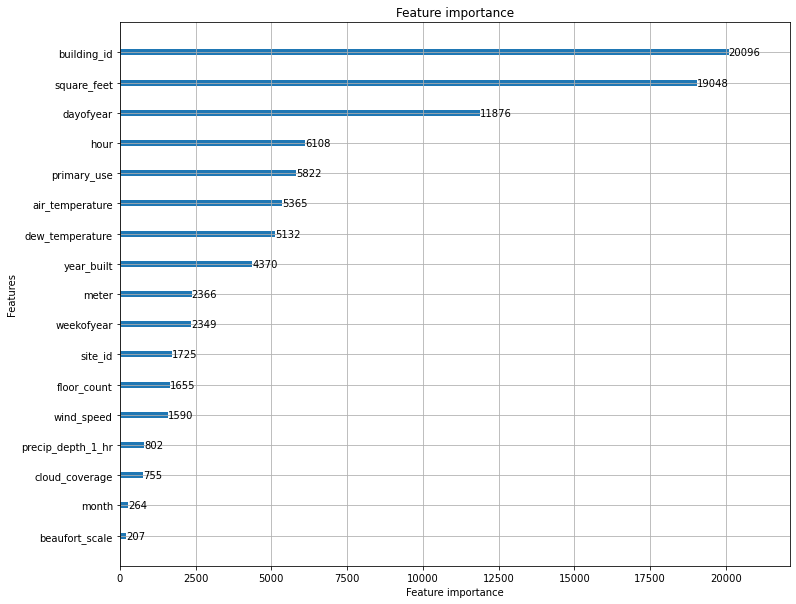

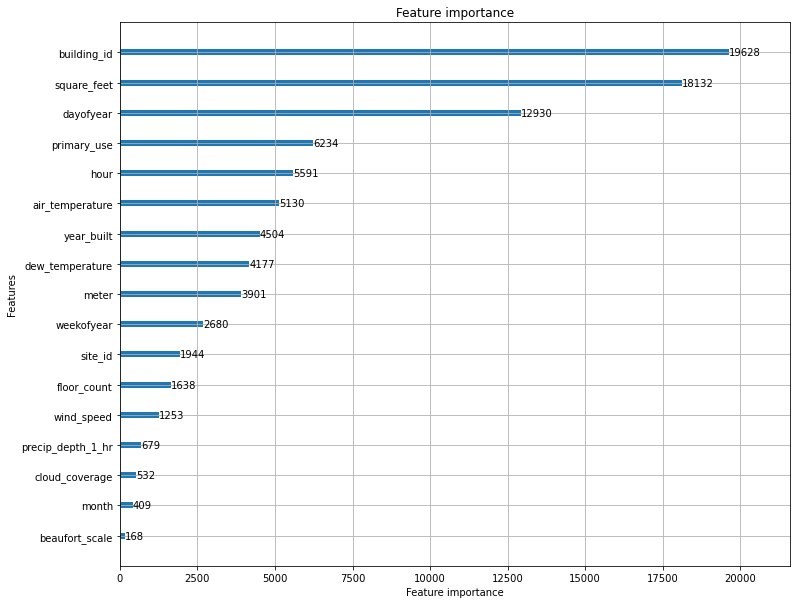

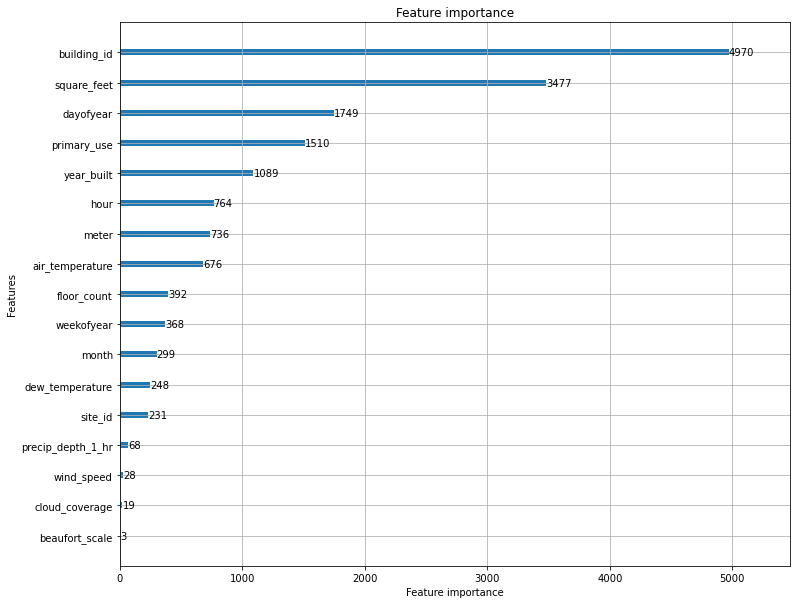

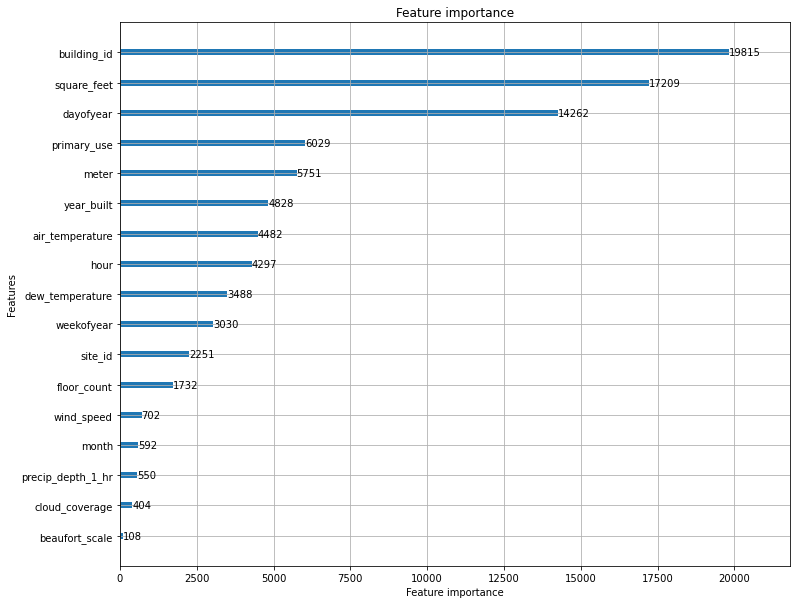

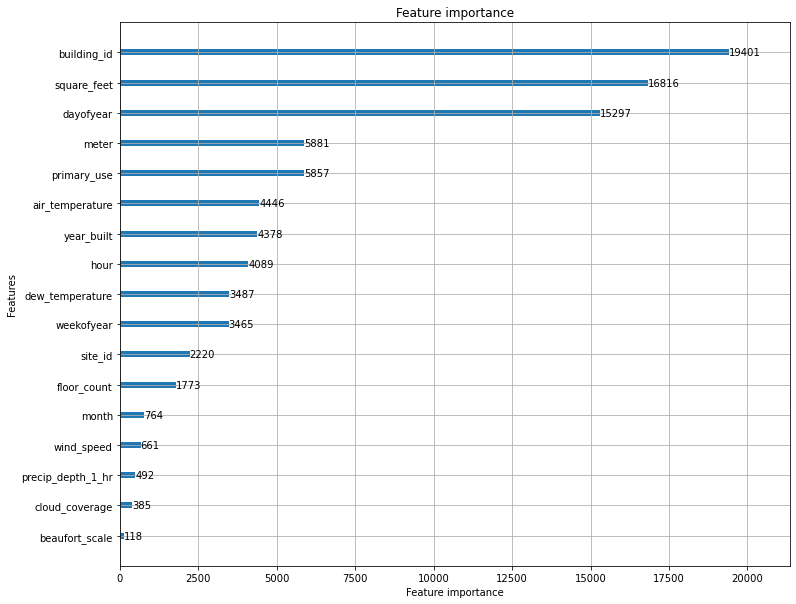

In [11]:
print_results(scores)
plot_importances(models)